## Chapter 2 - Improvements of the normal GARCH model
Panit (Luke) Arunanondchai

### Estimation of non-normal GARCH model

The function **ugarchfit()** does a joint estimation of all the mean, variance and distribution parameters. A general approach is to use a skewed student t distribution. You then need to estimate also the skew and shape parameters ξ and ν.

In this exercise, you fit the GARCH model with skewed student t distribution on a simulated return series called ret. The true model used to simulate has the following parameters 

In [ ]:
list(mu = 0, ar1 = 0, ma1 = 0, omega = 6*10^(-7), alpha1 = 0.07, beta1 = 0.9, skew = 0.9, shape = 5)

You will see that you obtain parameter estimates are close to the true parameters. The difference between the estimated and true parameter is called the estimation error. On long time series, the error is typically small.

In [5]:
library(rugarch)
load("ret.Rdata")
head(ret)

Warning message:
"package 'rugarch' was built under R version 3.5.2"Loading required package: parallel

Attaching package: 'rugarch'

The following object is masked from 'package:stats':

    sigma



                    [,1]
2008-06-20  0.0015954723
2008-06-23 -0.0074769985
2008-06-24  0.0003698231
2008-06-25 -0.0027400560
2008-06-26  0.0051705707
2008-06-27 -0.0034540448

In [8]:
str(ret)

An 'xts' object on 2008-06-20/2017-12-29 containing:
  Data: num [1:2400, 1] 0.0016 -0.00748 0.00037 -0.00274 0.00517 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : NULL
  Indexed by objects of class: [Date] TZ: UTC
  xts Attributes:  
 NULL


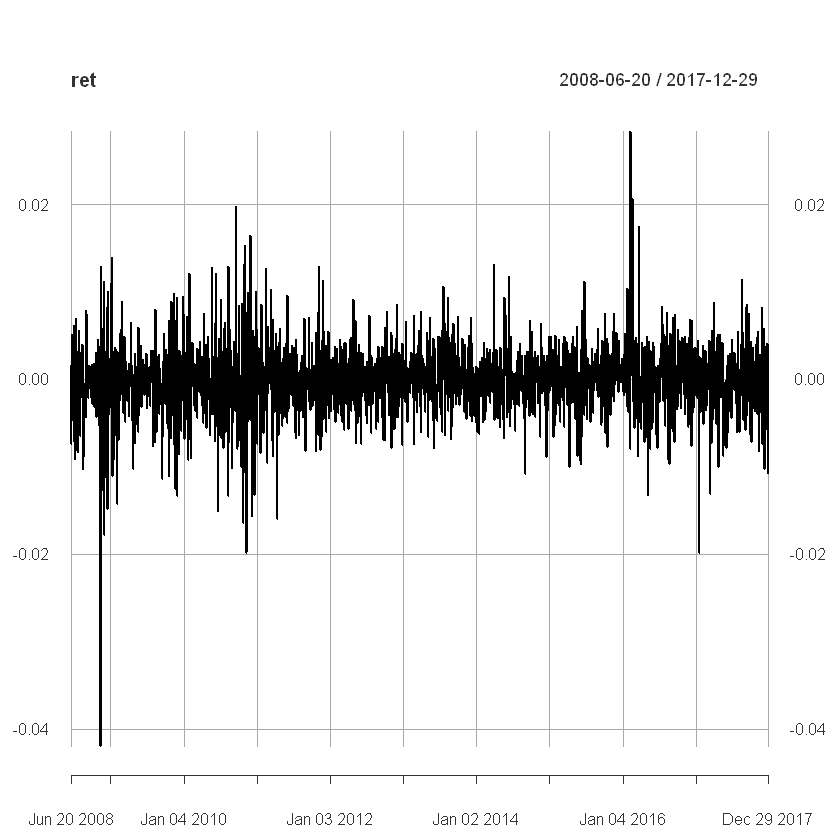

In [9]:
# Plot the return series
plot(ret)

# Specify the garch model to be used
garchspec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                       variance.model = list(model = "sGARCH"),
                        distribution.model = "sstd")

# Estimate the model
garchfit <- ugarchfit(data = ret, spec = garchspec)


In [10]:
# Inspect the coefficients
coef(garchfit)

mu        omega       alpha1        beta1         skew        shape 
1.413795e-05 5.966481e-07 6.656868e-02 8.956452e-01 9.026660e-01 5.014828e+00

In [ ]:
list(mu = 0, ar1 = 0, ma1 = 0, omega = 6*10^(-7), alpha1 = 0.07, beta1 = 0.9, skew = 0.9, shape = 5)

See how powerful this estimation method is? All estimated parameters are close to their true values!

## Standardized returns

A complete GARCH model requires to make an assumption about the distribution of the standardized returns. Once the model has been estimated you can verify the assumption by analyzing the standardized returns.

In this exercise your work begins after the estimation. The output from estimating the GARCH model using ugarchfit() is available as the variable garchfit in the console. The analyzed return series is available as the variable ret.

In [13]:
# Compute the standardized returns
stdret <- residuals(garchfit, standardize= TRUE)
head(stdret)

                  [,1]
2008-06-20  0.39375101
2008-06-23 -1.92087630
2008-06-24  0.08394304
2008-06-25 -0.67425589
2008-06-26  1.28726273
2008-06-27 -0.84771385

In [14]:
# Compute the standardized returns using fitted() and sigma()
stdret <- (ret - fitted(garchfit)) / sigma(garchfit)
head(stdret)

                  [,1]
2008-06-20  0.39375101
2008-06-23 -1.92087630
2008-06-24  0.08394304
2008-06-25 -0.67425589
2008-06-26  1.28726273
2008-06-27 -0.84771385

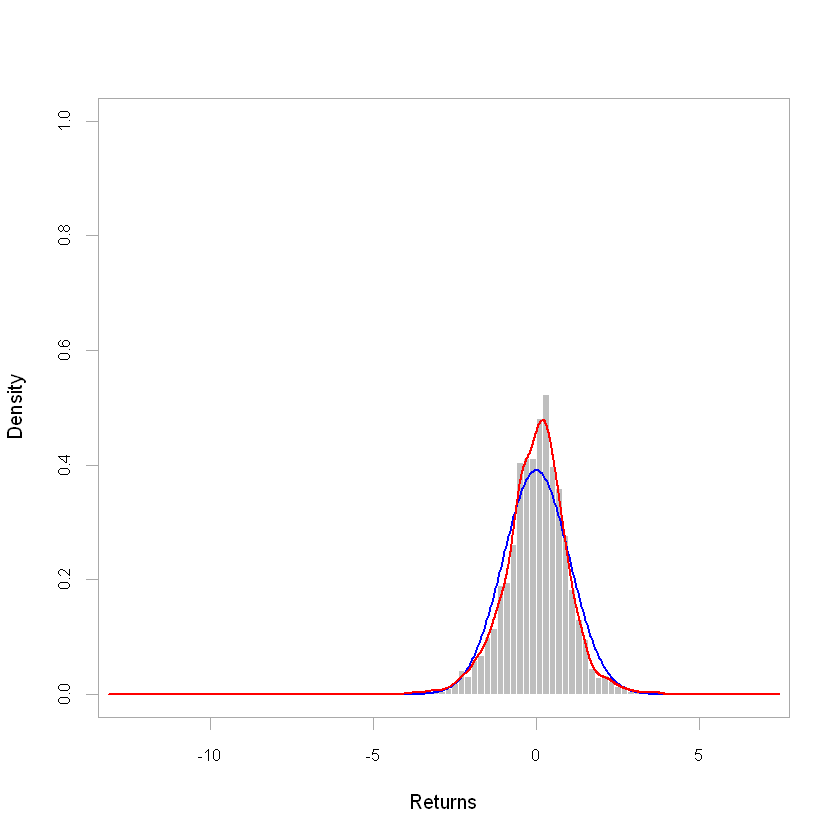

In [19]:
# Load the package PerformanceAnalytics and make the histogram
library(PerformanceAnalytics)
chart.Histogram(stdret, methods = c("add.normal","add.density" ), colorset = c("gray","red","blue"))


Note that the distribution of the standardized returns is not normal. There is asymmetry and fat tails. Setting distribution.model = "sstd" instead of distribution.model = "norm" leads to a more realistic GARCH model. You can also question the suitability of setting variance.model=list(model="sGARCH"). We now move on to using other GARCH models than the sGARCH model.

### News impact curve

Negative news about returns affect the variance more than positive news. The GJR GARCH model allows for asymmetric response of variance to positive and negative news. The news impact curve is a helpful tool to visualize the response of the variance to the surprise in returns.

The presence of a leverage effect matters for the choice of variance model. It does not matter for the distribution model, which can as well be normal or student t.

### Estimation of GJR garch model

Just like any GARCH model, the GJR GARCH model is used to predict volatility. We use this model now to predict the volatility of the daily returns of Microsoft over the period 1999 till 2017.

These returns are available in the console as the variable msftret. We have already computed the standard GARCH volatility predictions for you. They are available in the object sgarchvol.

In [20]:
load("msftret.Rdata")

In [23]:
# Specify the standard GARCH model
sgarchspec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                 variance.model = list(model = "sGARCH"),
                 distribution.model = "sstd")

# Estimate the model and compute volatility
sgarchfit <- ugarchfit(data = msftret, spec = sgarchspec)
sgarchvol <- sigma(sgarchfit)


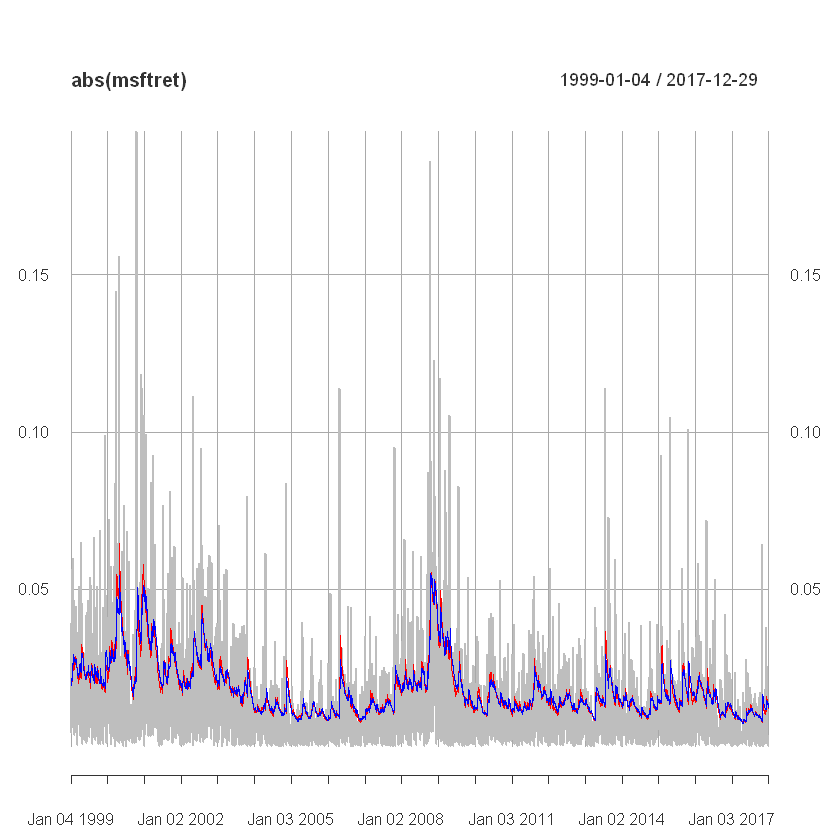

In [24]:
# Specify the GJR GARCH model
garchspec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                 variance.model = list(model = "gjrGARCH"),
                 distribution.model = "sstd")

# Estimate the model and compute volatility
gjrgarchfit <- ugarchfit(data = msftret, spec = garchspec)
gjrgarchvol <- sigma(gjrgarchfit)

# Compare volatility
plotvol <- plot(abs(msftret), col = "grey")
plotvol <- addSeries(gjrgarchvol, col = "red", on=1)
plotvol <- addSeries(sgarchvol, col = "blue", on=1)
plotvol

In the time series plot you can recognize the internet bubble and financial crisis.

### The AR(1)-GJR GARCH dynamics of MSFT returns

You have seen in the video that the sign of the autoregressive parameter in the AR(1) model depends on the market reaction to news

$$\mu_t = \mu+\rho(R_{t-1}-\mu)$$

A positive value of ρ is consistent with the interpretation that markets under-react to news leading to a momentum in returns. A negative value of ρ is consistent with the interpretation that markets over-react to news leading to a reversion in returns.

Are the daily Microsoft returns characterized by a momentum or a reversal effect in their AR(1) dynamics? Let's find this out by estimating the parameters of the AR(1)-GJR GARCH model using the daily Microsoft returns in msftret.

In [25]:
# Specify AR(1)-GJR GARCH model
garchspec <- ugarchspec(mean.model = list(armaOrder = c(1,0) ),
                        variance.model = list(model = "gjrGARCH"),
                        distribution.model = "sstd")

# Estimate the model
garchfit <- ugarchfit(data= msftret,spec=garchspec)

# Print the first two coefficients
coef(garchfit)[c(1:2)]

mu           ar1 
 0.0006100554 -0.0377992433

Since the AR(1) coefficient in the mean model is negative, we thus find a reversal effect in terms of predicted return. After an above average return, we expect a below average return. Following a below average return, we expect an above average return.

In [27]:
constmean_vol = sigma(sgarchfit)
ar1_mean = fitted(garchfit)
ar1_vol = sigma(garchfit)

### Effect of mean model on volatility predictions

Modelling the mean dynamics typically has a major effect on the obtained predicted returns, but only a minor effect on the volatility predictions. The effect on volatility predictions is so small that, if the interest is only in the volatility dynamics, usually one can ignore the mean dynamics and just assume the most simple specification, namely the constant mean model.

Let's test this for the daily returns of Microsoft. The predicted mean and volatility of the GARCH estimation under the assumption of constant mean and AR(1) are already available in the console as the variables constmean_mean, ar1_mean, constmean_vol and ar1_vol.

In [28]:
# GARCH-in-Mean specification and estimation
gim_garchspec <- ugarchspec( 
  mean.model = list(armaOrder = c(0,0), archm = TRUE, archpow = 2),
  variance.model = list(model = "gjrGARCH"), distribution.model = "sstd")
gim_garchfit <- ugarchfit(data = msftret , spec = gim_garchspec)

# Predicted mean returns and volatility of GARCH-in-mean
gim_mean <- fitted(gim_garchfit)
gim_vol <- sigma(gim_garchfit)

# Correlation between predicted return using AR(1) and GARCH-in-mean models
cor(ar1_mean, gim_mean)

# Correlation between predicted volatilities across mean.models
cor(merge(constmean_vol, ar1_vol, gim_vol))

0.05664686


,constmean_vol,ar1_vol,gim_vol
constmean_vol,1.0000000,0.9823409,0.9824070
ar1_vol,0.9823409,1.0000000,0.9998885
gim_vol,0.9824070,0.9998885,1.0000000


Note that there is a large disagreement between the predicted returns obtained using the AR(1) and GARCH-in-mean models, as shown by the low correlation. Because the mean return is close to zero for daily returns, these differences in mean prediction have little impact on the volatility predictions. Their correlation is is almost one. For simplicity, we consider henceforth only GARCH models with constant mean, unless the goal is to obtain time-varying mean predictions.

In [30]:
head(fitted(garchfit))
tail(fitted(garchfit))

                    [,1]
1999-01-04  6.100554e-04
1999-01-05  2.847708e-06
1999-01-06 -8.413254e-04
1999-01-07 -5.924313e-04
1999-01-08  8.205314e-04
1999-01-11  7.900751e-04

                   [,1]
2017-12-21 0.0007696432
2017-12-22 0.0006419515
2017-12-26 0.0006286942
2017-12-27 0.0006817407
2017-12-28 0.0004959025
2017-12-29 0.0006287050

In [32]:
head(msftret)
tail(msftret)

                   MSFT
1999-01-04  0.016674072
1999-01-05  0.039007141
1999-01-06  0.032422510
1999-01-07 -0.004958204
1999-01-08 -0.004152468
1999-01-11 -0.015847238

                    MSFT
2017-12-21 -0.0002337735
2017-12-22  0.0001169555
2017-12-26 -0.0012864196
2017-12-27  0.0036300331
2017-12-28  0.0001166690
2017-12-29 -0.0020998910

### Fixing GARCH parameters

The parameters of a GARCH model are estimated by maximum likelihood. Because of sampling uncertainty, the estimated parameters have for sure some estimation error. If we know the true parameter value, it is therefore best to impose that value and not to estimate it.

Let's do this in case of the daily EUR/USD returns available in the console as the variable EURUSDret and for which an AR(1)-GARCH model with skewed student t distribution has already been estimated, and made available as the ugarchfit object called flexgarchfit.

In [36]:
load("EURUSDret.Rdata")

flexgarchspec = ugarchspec( mean.model = list(armaOrder = c(1,0)),
                        variance.model = list(model = "sGARCH"), 
                        distribution.model = "sstd")
flexgarchfit = ugarchfit(data = EURUSDret, spec = flexgarchspec)

mu           ar1         omega        alpha1         beta1 
-2.454957e-05  1.229478e-04  9.575141e-08  3.053375e-02  9.671562e-01 
         skew         shape 
 1.014341e+00  8.909174e+00

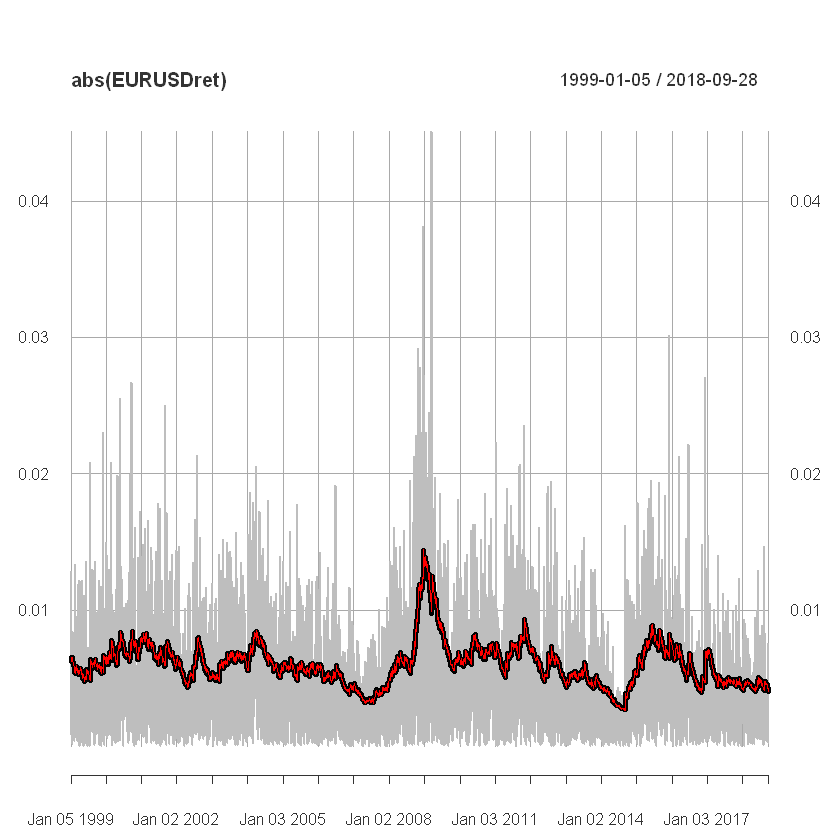

In [37]:
# Print the flexible GARCH parameters
coef(flexgarchfit)

# Restrict the flexible GARCH model by impose a fixed ar1 and skew parameter
rflexgarchspec <- flexgarchspec
setfixed(rflexgarchspec) <- list(ar1 = 0, skew = 1)

# Estimate the restricted GARCH model
rflexgarchfit <- ugarchfit(data = EURUSDret,  spec = rflexgarchspec)

# Compare the volatility of the unrestricted and restriced GARCH models
plotvol <- plot(abs(EURUSDret), col = "grey")
plotvol <- addSeries(sigma(flexgarchfit), col = "black", lwd = 4, on=1 )
plotvol <- addSeries(sigma(rflexgarchfit), col = "red", on=1)
plotvol

The two volatility series completely overlap. The parameter restrictions thus match with the observed return behavior.

### Parameter bounds and impact on forecasts

Let's take again the flexible GARCH model specification for which the estimated coefficients are printed in the console. Now assume that you believe that the GARCH parameter α should be between 0.05 and 0.1, while the β parameter is between 0.8 and 0.95. You are asked here to re-estimate the model by imposing those bounds and see the effect on the volatility forecasts for the next ten days obtained using ugarchforecast.

In [38]:
# Define bflexgarchspec as the bound constrained version
bflexgarchspec <- flexgarchspec
setbounds(bflexgarchspec) <- list(alpha1 = c(0.05,0.2), beta1 = c(0.8,0.95))

# Estimate the bound constrained model
bflexgarchfit <- ugarchfit(data = EURUSDret, spec = bflexgarchspec)

# Inspect coefficients
coef(bflexgarchfit)

# Compare forecasts for the next ten days
cbind(sigma(ugarchforecast(flexgarchfit, n.ahead = 10)),
      sigma(ugarchforecast(bflexgarchfit, n.ahead = 10)))

mu           ar1         omega        alpha1         beta1 
-2.585129e-05  1.776661e-03  1.681685e-07  5.000000e-02  9.479078e-01 
         skew         shape 
 1.011150e+00  8.491777e+00

,2018-09-28,2018-09-28
T+1,0.004192988,0.004157471
T+2,0.004199558,0.004173317
T+3,0.004206102,0.004189069
T+4,0.004212622,0.004204730
T+5,0.004219116,0.004220300
T+6,0.004225585,0.004235781
T+7,0.004232030,0.004251172
T+8,0.004238450,0.004266477
T+9,0.004244845,0.004281695
T+10,0.004251216,0.004296827


Imposing the bound constraints changes the volatility forecasts. In Chapter 3 you will learn how to decide between two volatility forecasting approaches based on their precision.

### Variance targeting

Financial return volatility clusters through time: periods of above average volatility are followed by period of below average volatility. The long run prediction is that:

- when volatility is high, it will decrease and revert to its long run average.
- when volatility is low, it will increase and revert to its long run average.

In the estimation of GARCH models we can exploit this mean reversion behavior of volatility by means of volatility targeting. We then estimate the GARCH parameters in such a way that the long run volatility implied by the GARCH model equals the sample standard deviation.

Let's do this for the EUR/USD returns.

In [39]:
# Complete the specification to do variance targeting
garchspec <- ugarchspec(mean.model = list(armaOrder = c(0,0)),
                        variance.model = list(model = "sGARCH",
                                         variance.targeting = TRUE),
                        distribution.model = "std")

# Estimate the model
garchfit <- ugarchfit(data = EURUSDret, spec = garchspec)

# Print the GARCH model implied long run volatility
sqrt(uncvariance(garchfit))

# Verify that it equals the standard deviation (after rounding)
all.equal(sqrt(uncvariance(garchfit)), sd(EURUSDret), tol = 1e-4)

[1] 0.00619371

[1] TRUE